In [11]:
import numpy as np
import tensorflow as tf
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from PIL import Image
from scipy import ndimage
from os import listdir
from os.path import isfile
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
def predict_image(model, image_array):
    labels = ["Dump Truck", "Excavator"]
    prediction = large_cnn_model.predict(image_array.reshape(1, height, width, 3))[0]
    return labels[np.argmax(prediction)], prediction[np.argmax(prediction)]

## Preparing The Images

In [13]:
def load_photos(directory, resize_to):
    images = dict()
    image_files = [f for f in listdir(directory) if isfile(directory+f)]
    for i,name in enumerate(image_files):
        # load an image from file
        filename = directory + name
#         print(filename)
        image = load_img(filename, target_size=resize_to)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#         # prepare the image for the VGG model
#         image = preprocess_input(image)
        # get image id
        image_id = str(i) + "_" + directory.split('/')[-2]
        images[image_id] = image/255
    return images

In [14]:
# specify width and height of the image
width = 300
height = 200
# load images
dumptruck_dir = "../Data/Dump Truck Komatsu/"
excavator_dir = "../Data/Excavator Komatsu/"
dumptruck_images = load_photos(dumptruck_dir, resize_to=(height, width))
excavator_images = load_photos(excavator_dir, resize_to=(height, width))
all_images = {**dumptruck_images, **excavator_images}
print('Loaded Dump Truck Images: %d' % len(dumptruck_images))
print('Loaded Excavator Images: %d' % len(excavator_images))
print('Total Loaded Images: %d' % len(all_images))

Loaded Dump Truck Images: 486
Loaded Excavator Images: 707
Total Loaded Images: 1193


In [15]:
list_images_array = []
list_images_labels = []
for image_id in all_images.keys():
    list_images_array.append(all_images[image_id][0])
    label = image_id.split("_")[1]
    binary_label = 1 if label == 'Excavator Komatsu' else 0
    list_images_labels.append(binary_label)
list_images_array = np.array(list_images_array)
list_images_labels = np.array(list_images_labels)

#Split images for training-testing
X_train, X_test, y_train, y_test = train_test_split(list_images_array, list_images_labels, 
                                                    test_size=0.25, random_state=42)
y_train_hot = np_utils.to_categorical(y_train)
y_test_hot = np_utils.to_categorical(y_test)

## Build The Neural Network

We will build larger CNN with topology as follows;

1. Convolutional laye with 30 feature maps of size 5x5
2. Pooling layer taking the max over 2x2 patches
3. Convolutional layer with 15 feature maps of size 3x3
4. Pooling layer taking the max over 2x2 pathes
5. Dropout layer with a probability of 20%
6. Flatten layer
7. Fully connected layer with 128 neurons and ReLu activation
8. Fully connected layer with 50 neurons and ReLu activation
9. Output layer

In [109]:
def larger_CNN_model():
    model = Sequential()
    model.add(Conv2D(30, (5,5), input_shape=(height, width, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(15, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy']
                 )
    return model

In [110]:
#build the model
large_cnn_model = larger_CNN_model()
#fit the model
large_cnn_model.fit(X_train, y_train_hot, 
              validation_data=(X_test, y_test_hot),
              epochs=10, batch_size=200, verbose=2
             )
#evaluation of the model
scores = large_cnn_model.evaluate(X_test, y_test_hot, verbose=0)
print("Error for CNN Model: {0}%".format(100-scores[1]*100))
large_cnn_model.save_weights('hd_pc_classifier_try_1.h5')

Train on 894 samples, validate on 299 samples
Epoch 1/10
 - 124s - loss: 0.8143 - acc: 0.5034 - val_loss: 0.6736 - val_acc: 0.5920
Epoch 2/10
 - 142s - loss: 0.6762 - acc: 0.5928 - val_loss: 0.6617 - val_acc: 0.5920
Epoch 3/10
 - 138s - loss: 0.6506 - acc: 0.6074 - val_loss: 0.6268 - val_acc: 0.5987
Epoch 4/10
 - 143s - loss: 0.5787 - acc: 0.7136 - val_loss: 0.5372 - val_acc: 0.7525
Epoch 5/10
 - 149s - loss: 0.4651 - acc: 0.7964 - val_loss: 0.4660 - val_acc: 0.7926
Epoch 6/10
 - 255s - loss: 0.4950 - acc: 0.7640 - val_loss: 0.5301 - val_acc: 0.7425
Epoch 7/10
 - 273s - loss: 0.4480 - acc: 0.8065 - val_loss: 0.4726 - val_acc: 0.7592
Epoch 8/10
 - 283s - loss: 0.3591 - acc: 0.8434 - val_loss: 0.3950 - val_acc: 0.8595
Epoch 9/10
 - 127s - loss: 0.3106 - acc: 0.8647 - val_loss: 0.4252 - val_acc: 0.7993
Epoch 10/10
 - 113s - loss: 0.2792 - acc: 0.8803 - val_loss: 0.3824 - val_acc: 0.8227
Error for CNN Model: 17.725752428622556%


In [111]:
large_cnn_model.save_weights('hd_pc_classifier_try_2.h5')

In [106]:
first_model.load_weights('hd_pc_classifier_try_1.h5')

## Let's see the result

Prdicted: Dump Truck (91.8%)


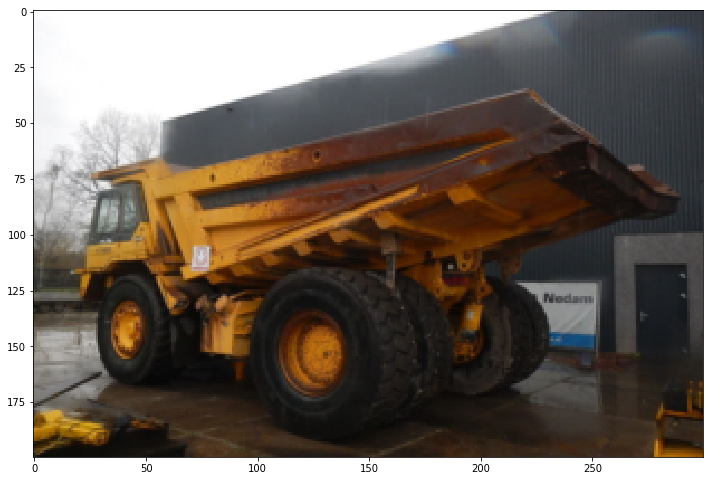

In [193]:
idx = int(np.random.rand()*len(y_test))
image = X_test[idx]
predicted_label, confidence = predict_image(large_cnn_model, image)
title = "Prdicted: {0} ({1}%)".format(predicted_label, np.round(confidence*100, 2))
print(title)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()